In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import logging
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from darts import TimeSeries
from darts.models import NaiveMean, NBEATSModel, RNNModel, TCNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode
from darts.datasets import *

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [2]:
#Working with the raw Solcast dataset until we finalize the preprocessing pipeline
#Removing timezone info for convenience
df = pd.read_csv('40.554572_25.084034_Solcast_PT60M.csv')

df['PeriodStart'] = pd.to_datetime(df['PeriodStart'])
df['PeriodStart'] = df['PeriodStart'].dt.tz_localize(None)
df.set_index('PeriodStart', inplace = True)

df.rename(columns = {'Ghi': 'values'}, inplace = True)
df = df[['values']]

df.head(20)

,values
PeriodStart,
2007-01-01 01:00:00,0
2007-01-01 02:00:00,0
2007-01-01 03:00:00,0
2007-01-01 04:00:00,0
2007-01-01 05:00:00,2
2007-01-01 06:00:00,88
2007-01-01 07:00:00,232
2007-01-01 08:00:00,348
2007-01-01 09:00:00,427


In [3]:
#Resampling the time series to a monthly frequency
df = df.resample('M').mean()
df

,values
PeriodStart,
2007-01-31,99.130552
2007-02-28,101.901786
2007-03-31,176.571237
2007-04-30,249.636111
2007-05-31,264.572581
...,...
2021-09-30,194.098611
2021-10-31,124.873656
2021-11-30,81.448611


## Time Series Analysis
In this section, we are going to analyze the dataset so we can understand its basic statistical properties, something that can be accomplished by creating various types of visualizations.

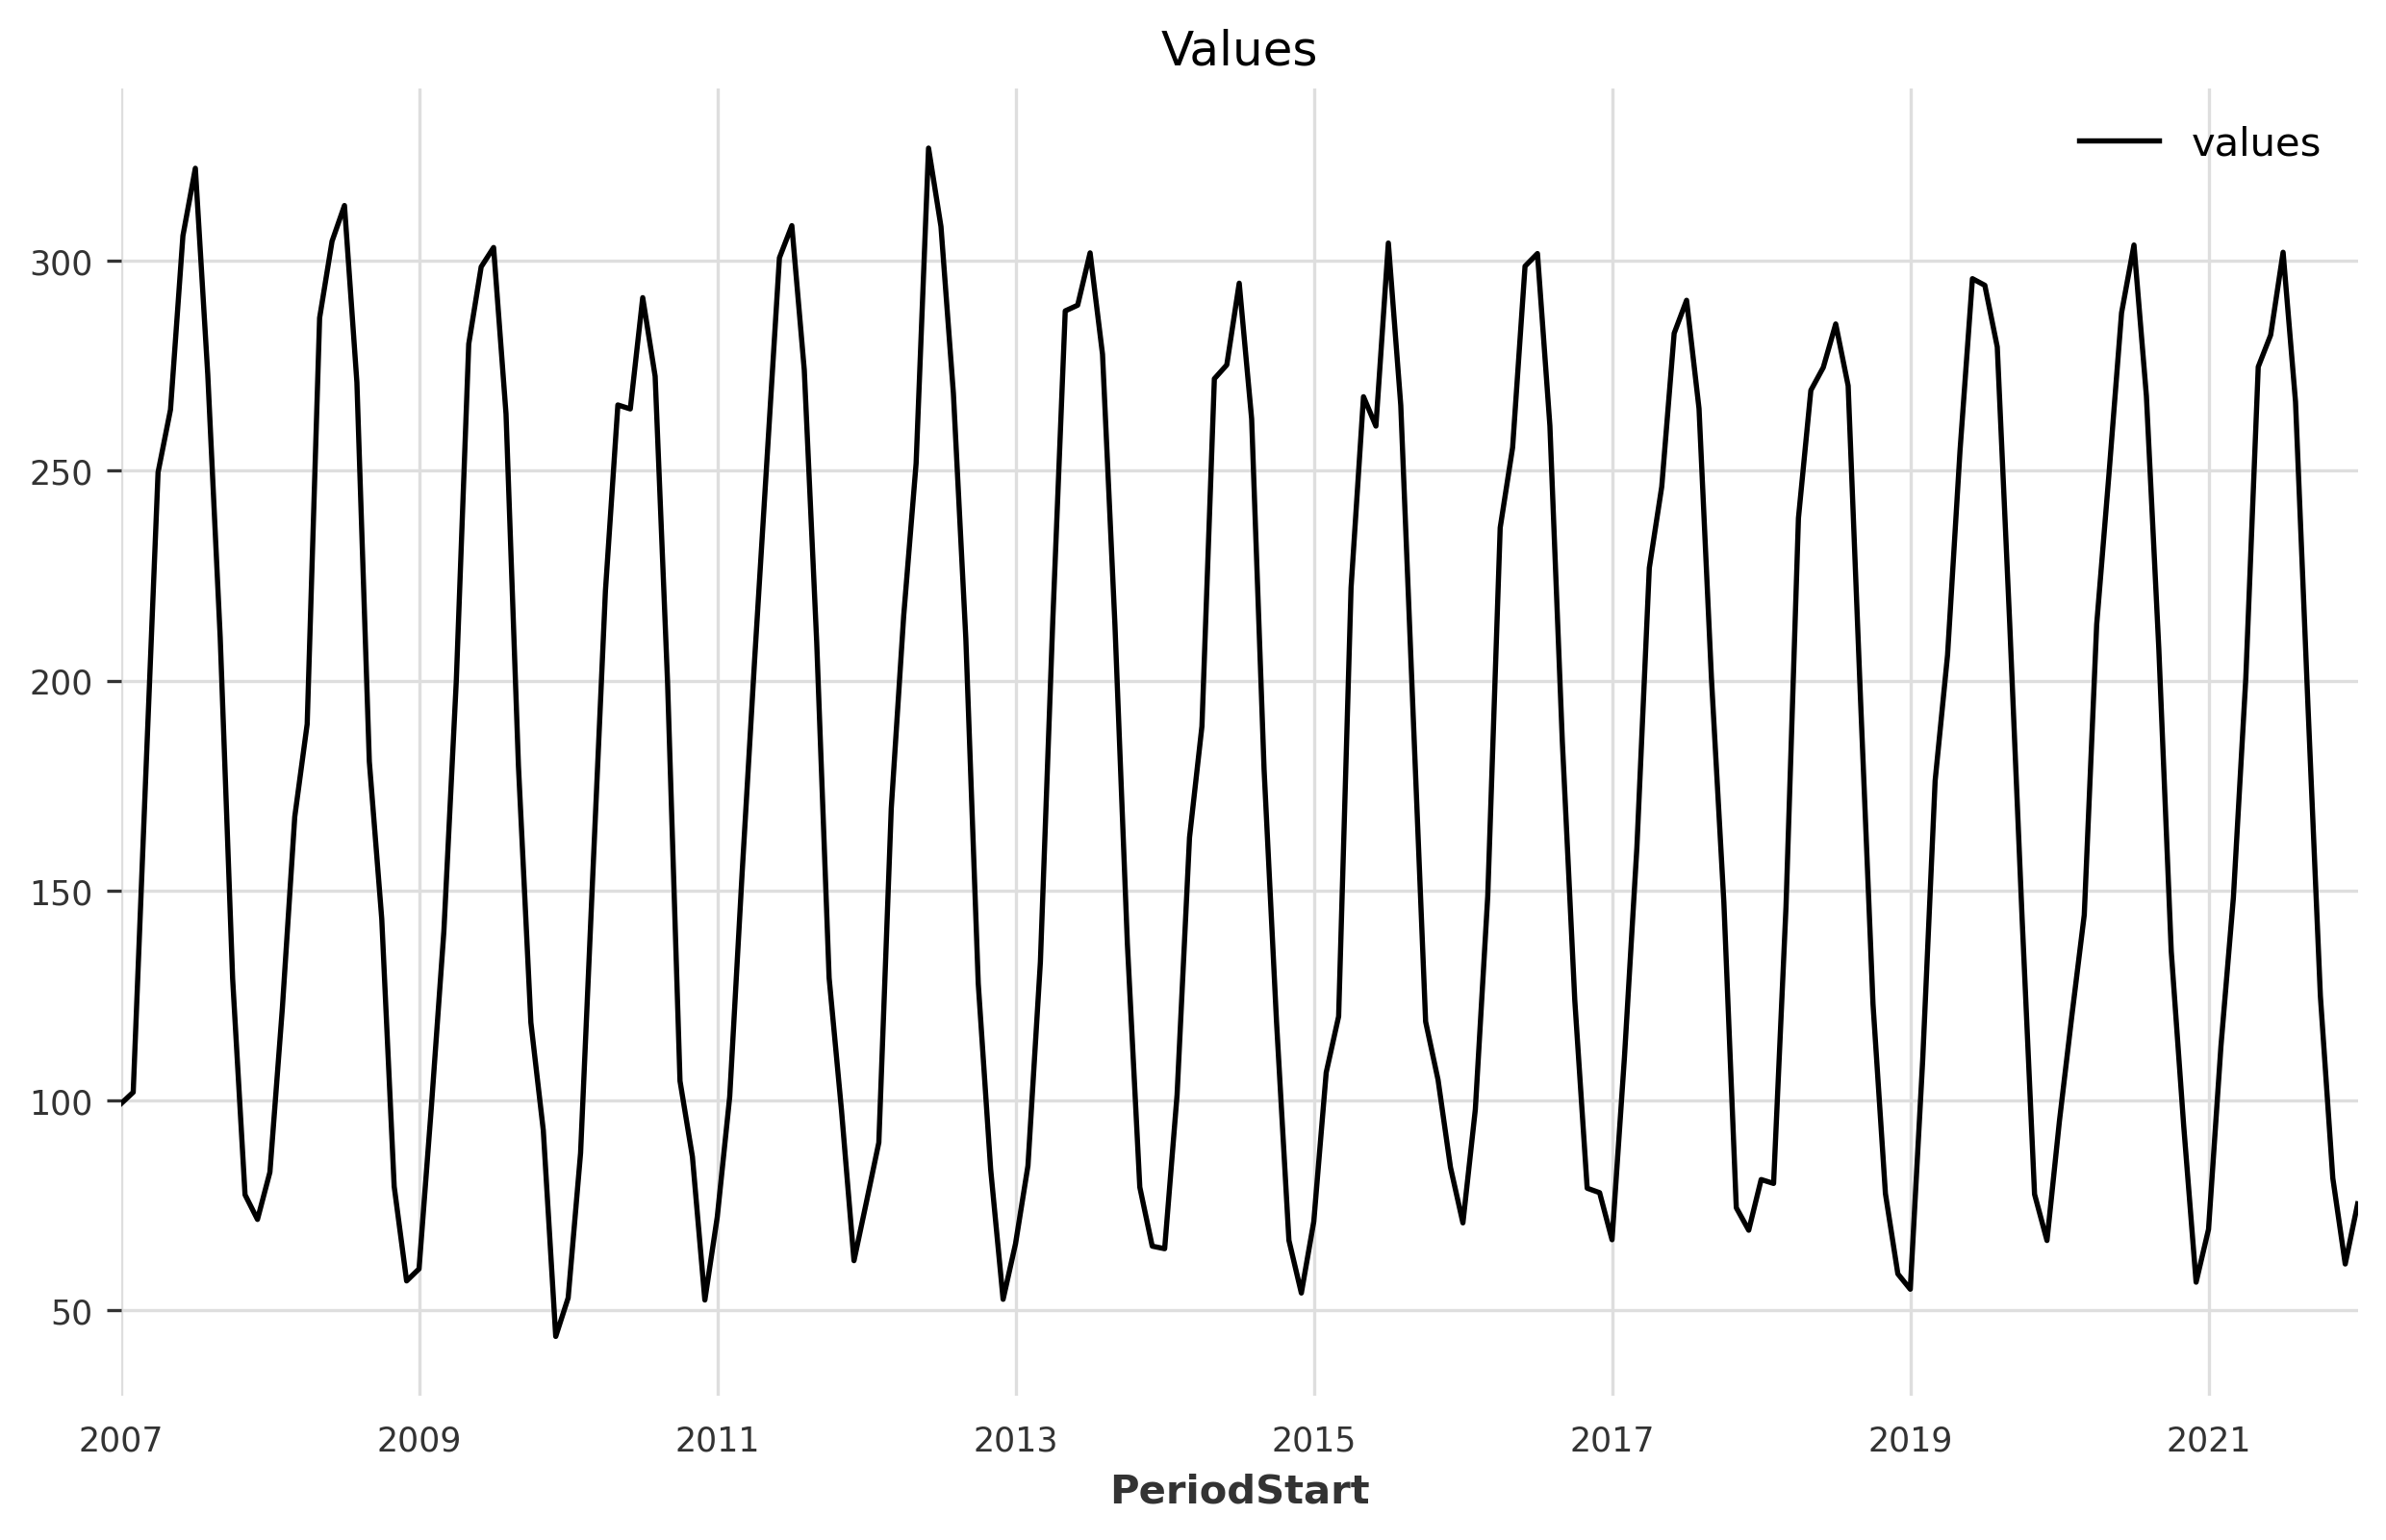

In [4]:
df.plot(figsize=(10,6))
plt.title('Values')

plt.show()

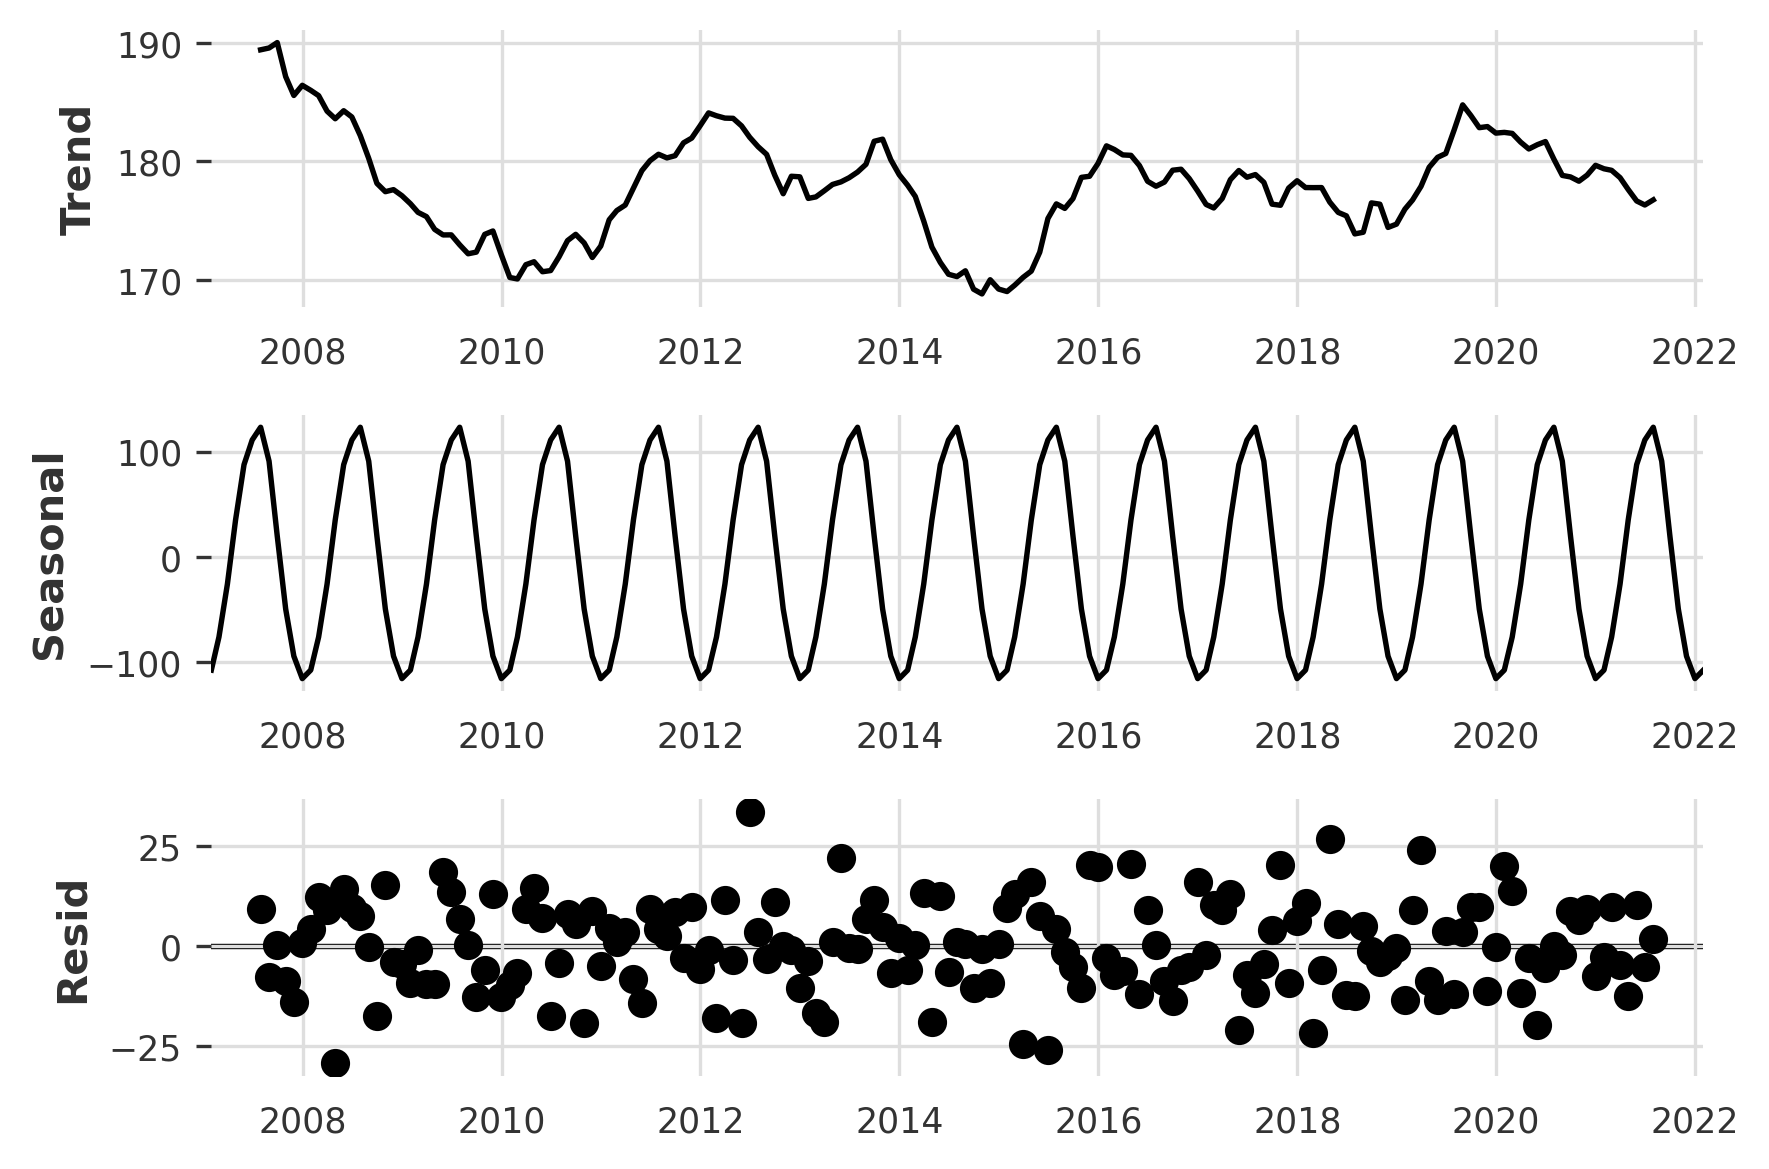

In [5]:
result = seasonal_decompose(df['values'])

result.plot(observed = False)

plt.show()

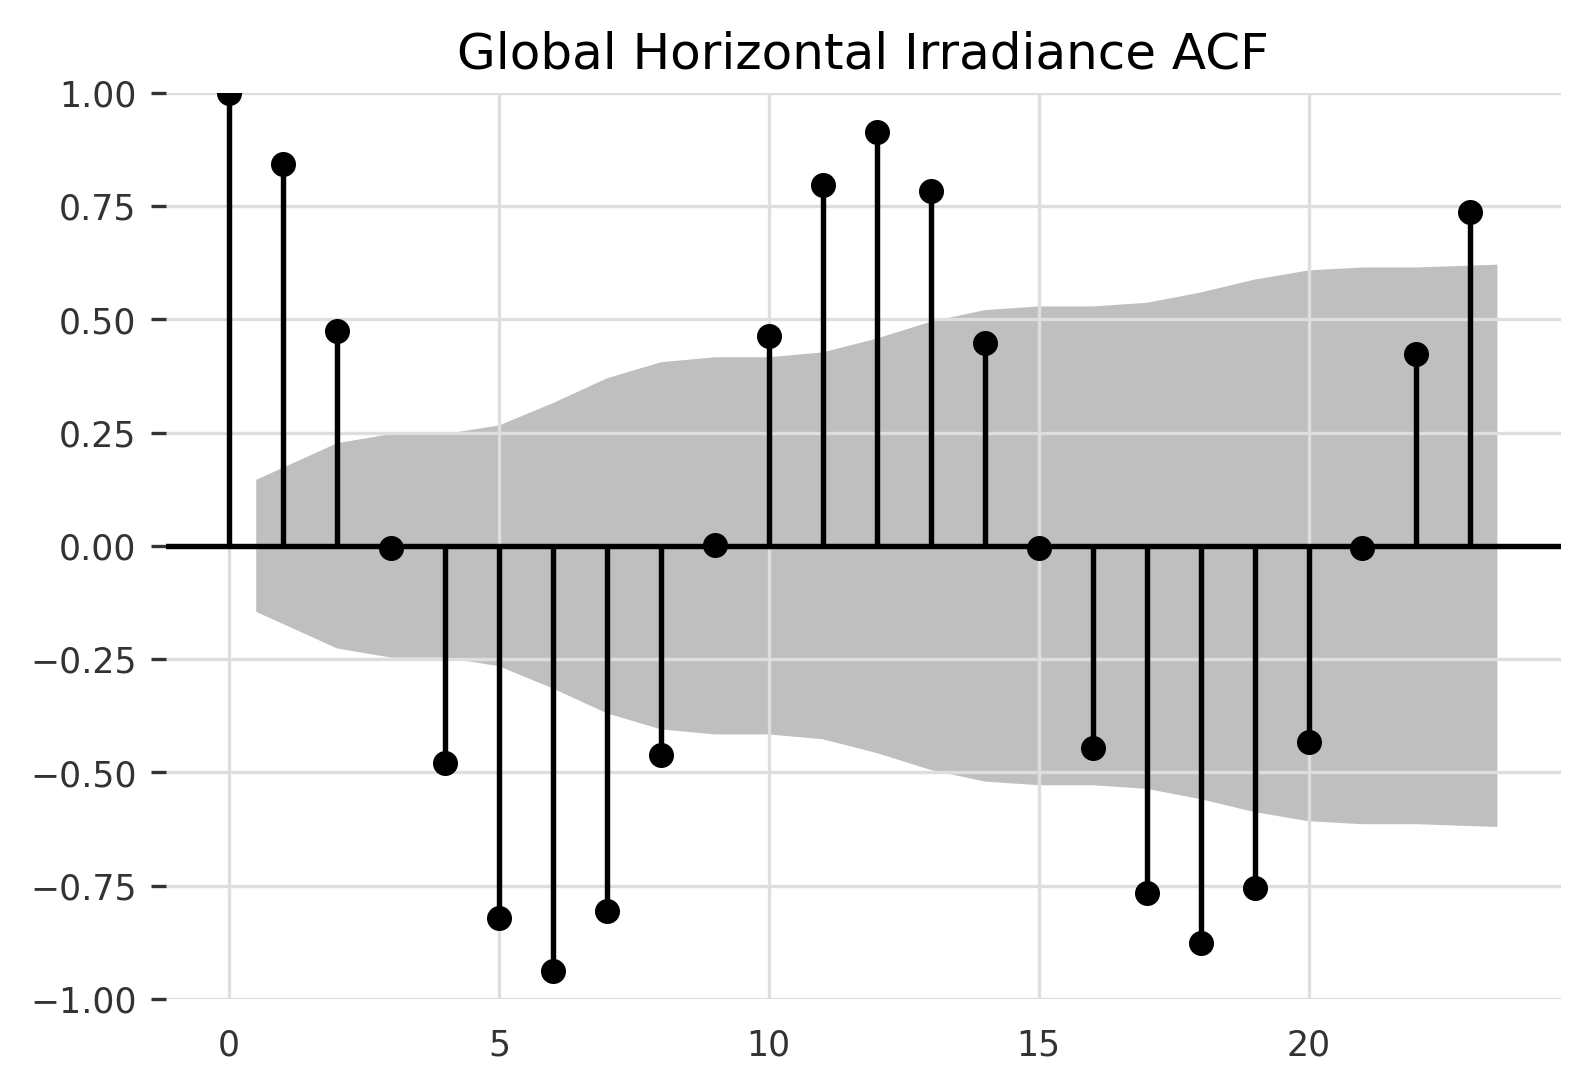

In [6]:
#fig, ax = plt.subplots(figsize = (10,6))

plot_acf(df['values'], title = 'Global Horizontal Irradiance ACF')

plt.show()

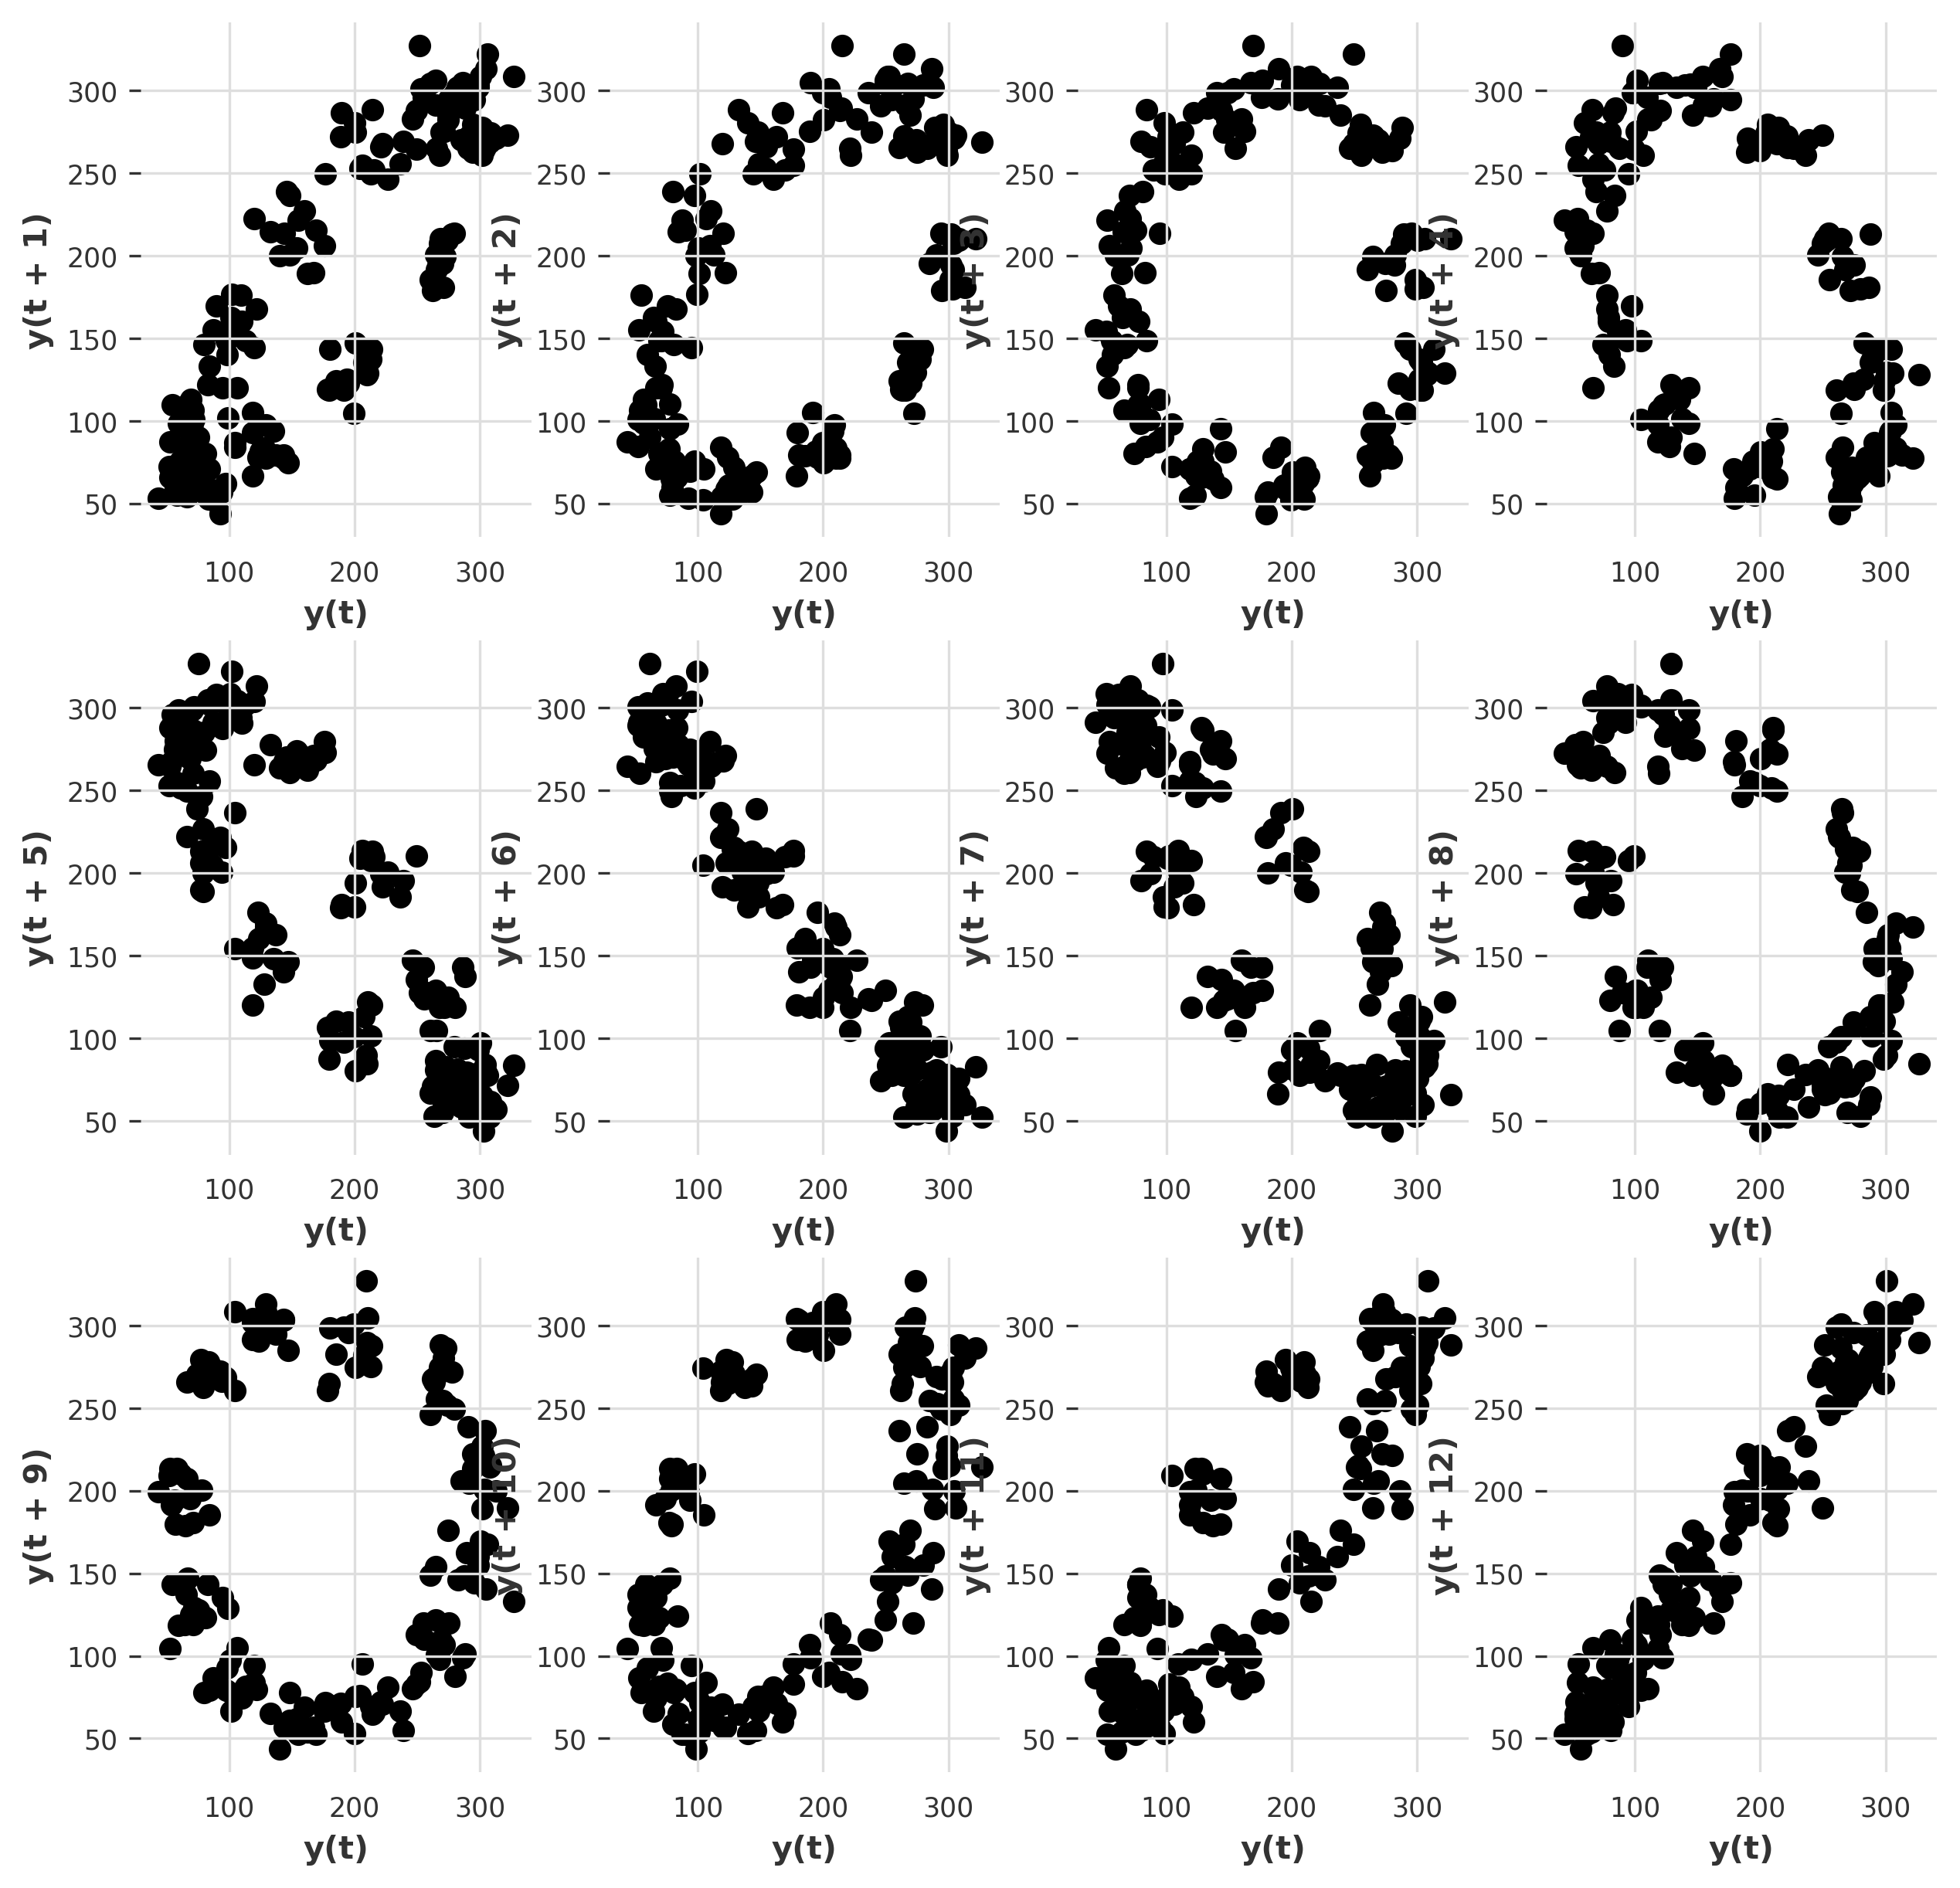

In [7]:
fig, axes = plt.subplots(3, 4, figsize = (10, 10))

for ax, i in zip(axes.flatten(), range(1, 13)):
    pd.plotting.lag_plot(df['values'], lag=i, ax = ax)

In [8]:
#Loading the pandas dataframe to a TimeSeries object
#As required by the Darts library
series = TimeSeries.from_dataframe(df)

### Creating Utility Functions

In [9]:
def plot_backtest(series, model, start, retrain = True):
    historical_fcast = model.historical_forecasts(series, start=start, forecast_horizon=1,
                                              verbose = True, retrain = retrain)
    series.plot(label='data')
    historical_fcast.plot(label= 'Forecasting Model Backtest')
    plt.title('SMAPE = {:.2f}%'.format(smape(historical_fcast, series)))
    plt.show()

We have created the `plot_backtest()` utility function to evaluate model accuracy. This will be accomplished by using the `backtest()` function that computes error scores between the forecasts the model would have produced with an expanding training window over series and the actual values.

### Creating a Naive Forecasting Model
We begin by setting a baseline accuracy with a naive forecasting model. This will help us evaluate the performance of more complex models, that theoretically should have higher accuracy than the baseline.

  0%|          | 0/37 [00:00<?, ?it/s]

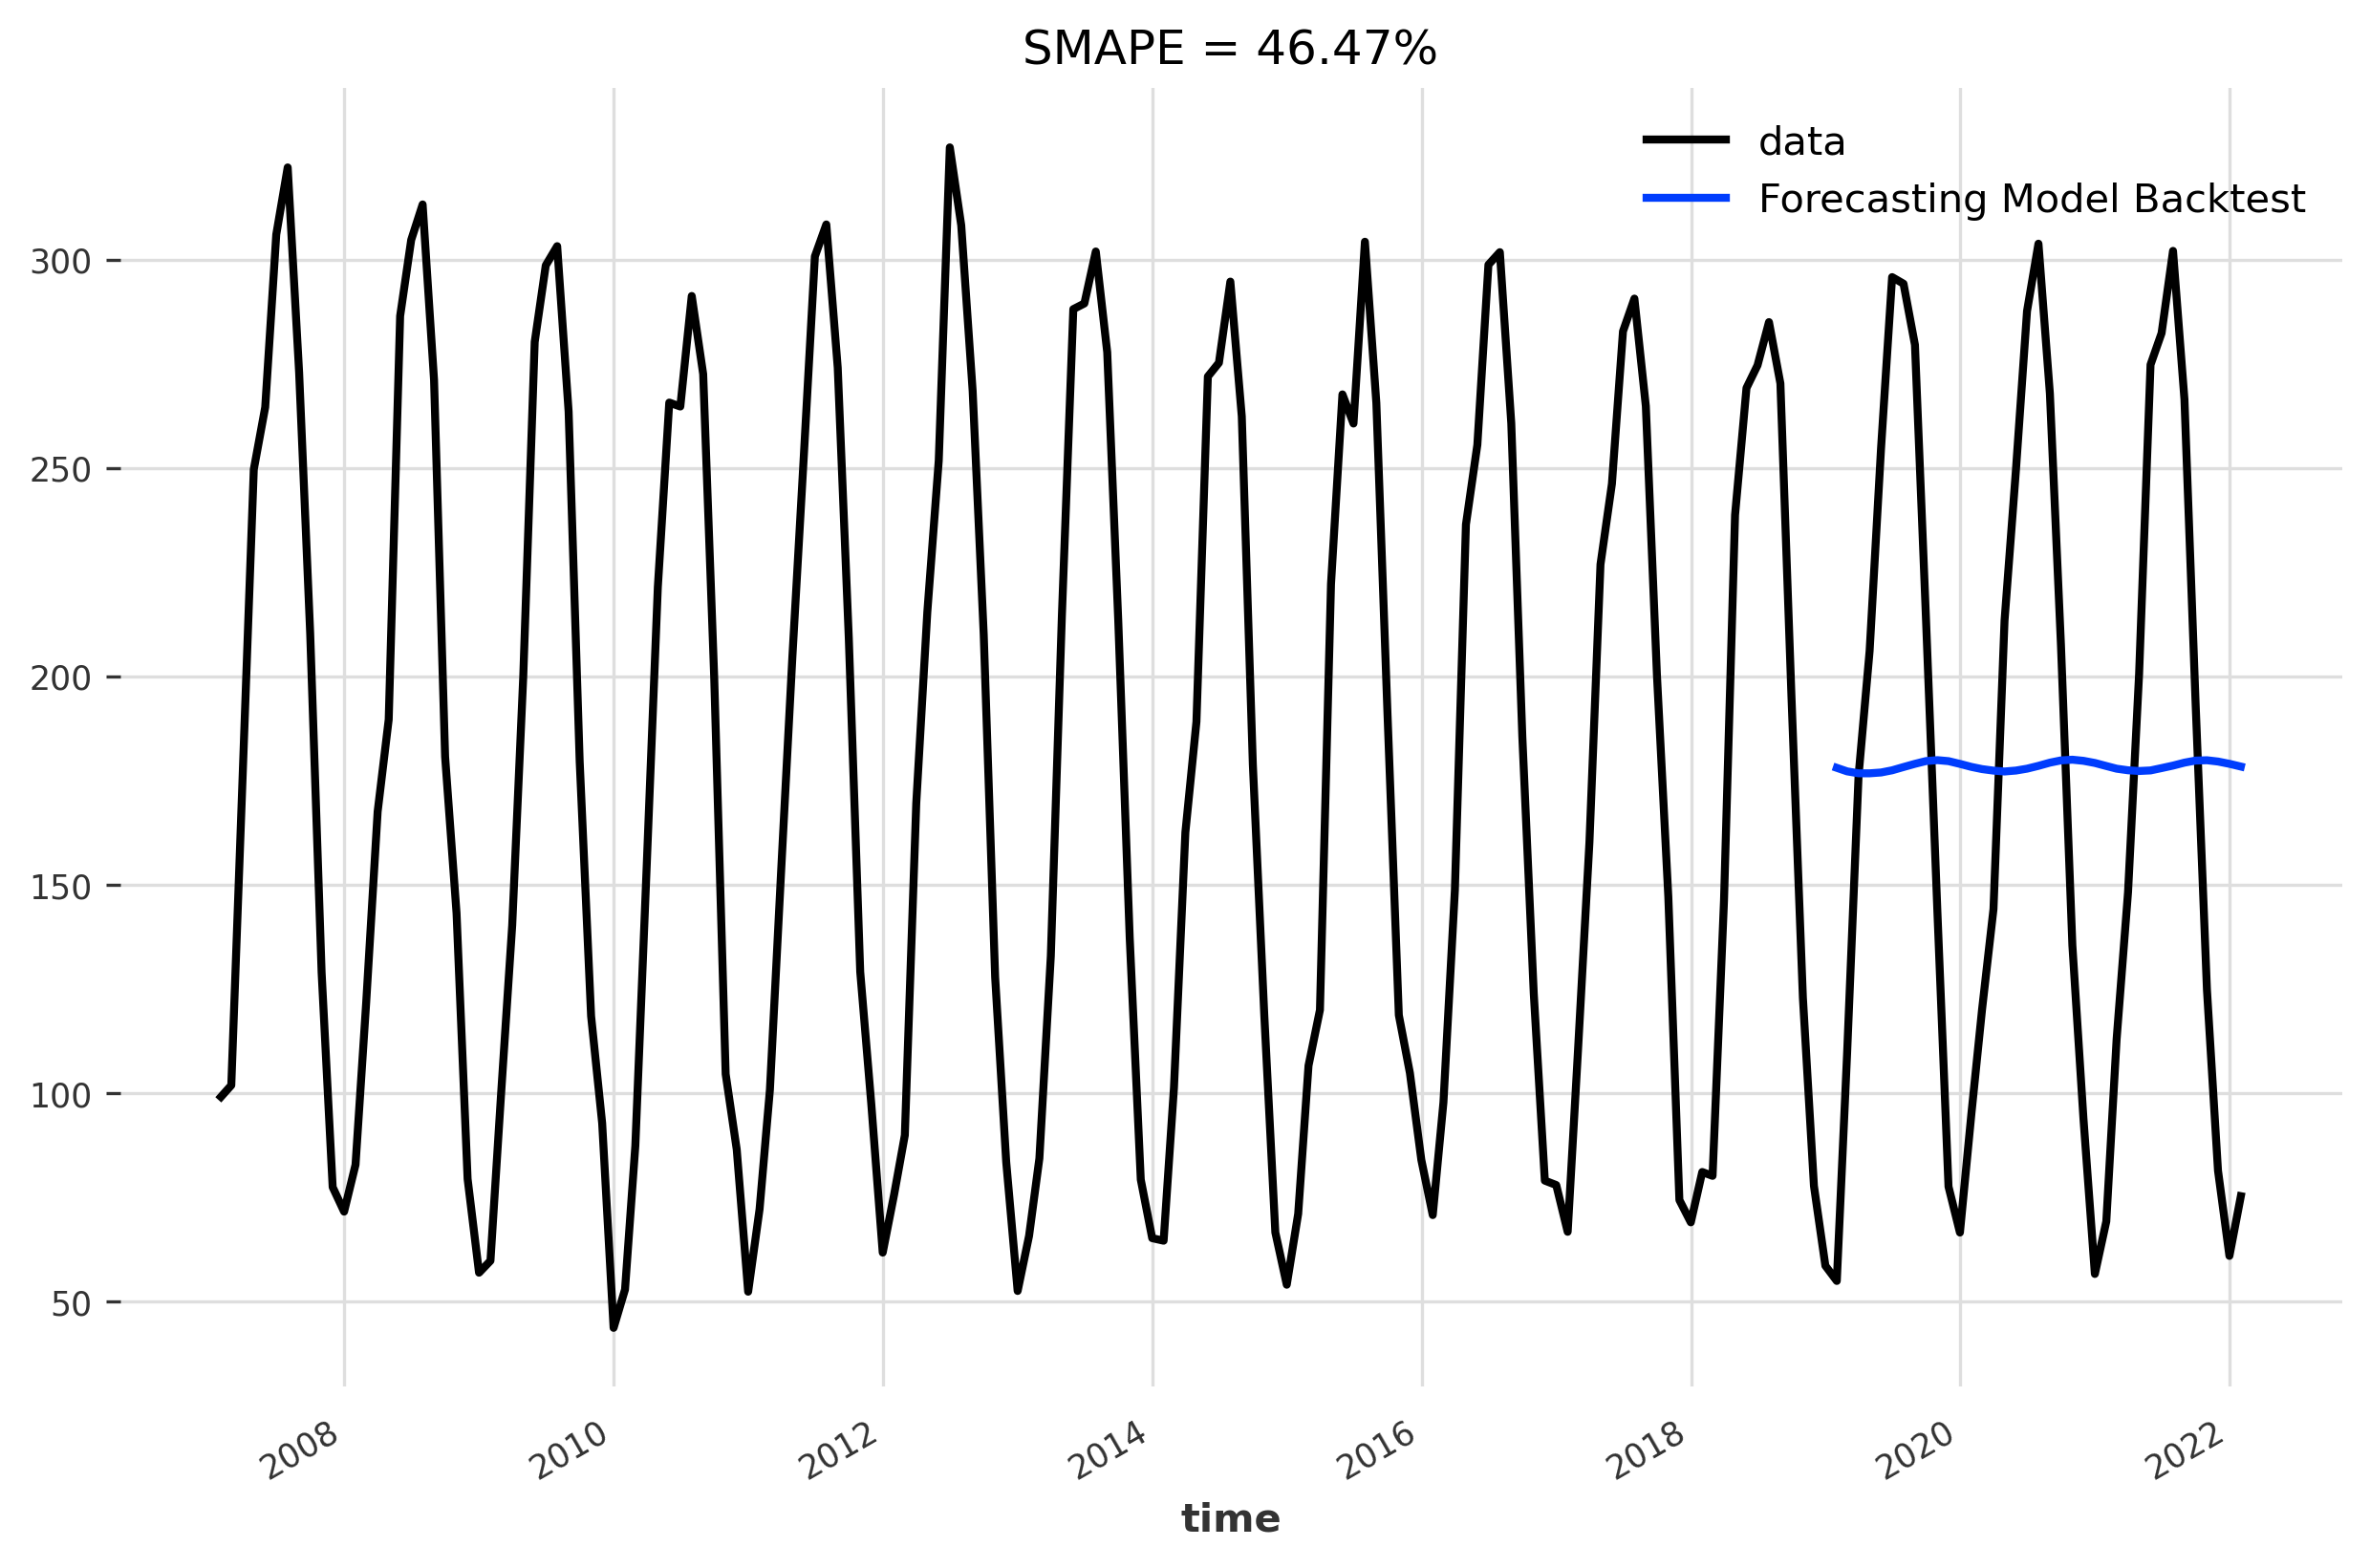

In [10]:
model = NaiveMean()
start = pd.Timestamp('20190131')

plt.figure(figsize = (10, 6))

plot_backtest(series, model, start)

plt.show()

### Creating a RNN Forecasting Model

  0%|          | 0/37 [00:00<?, ?it/s]

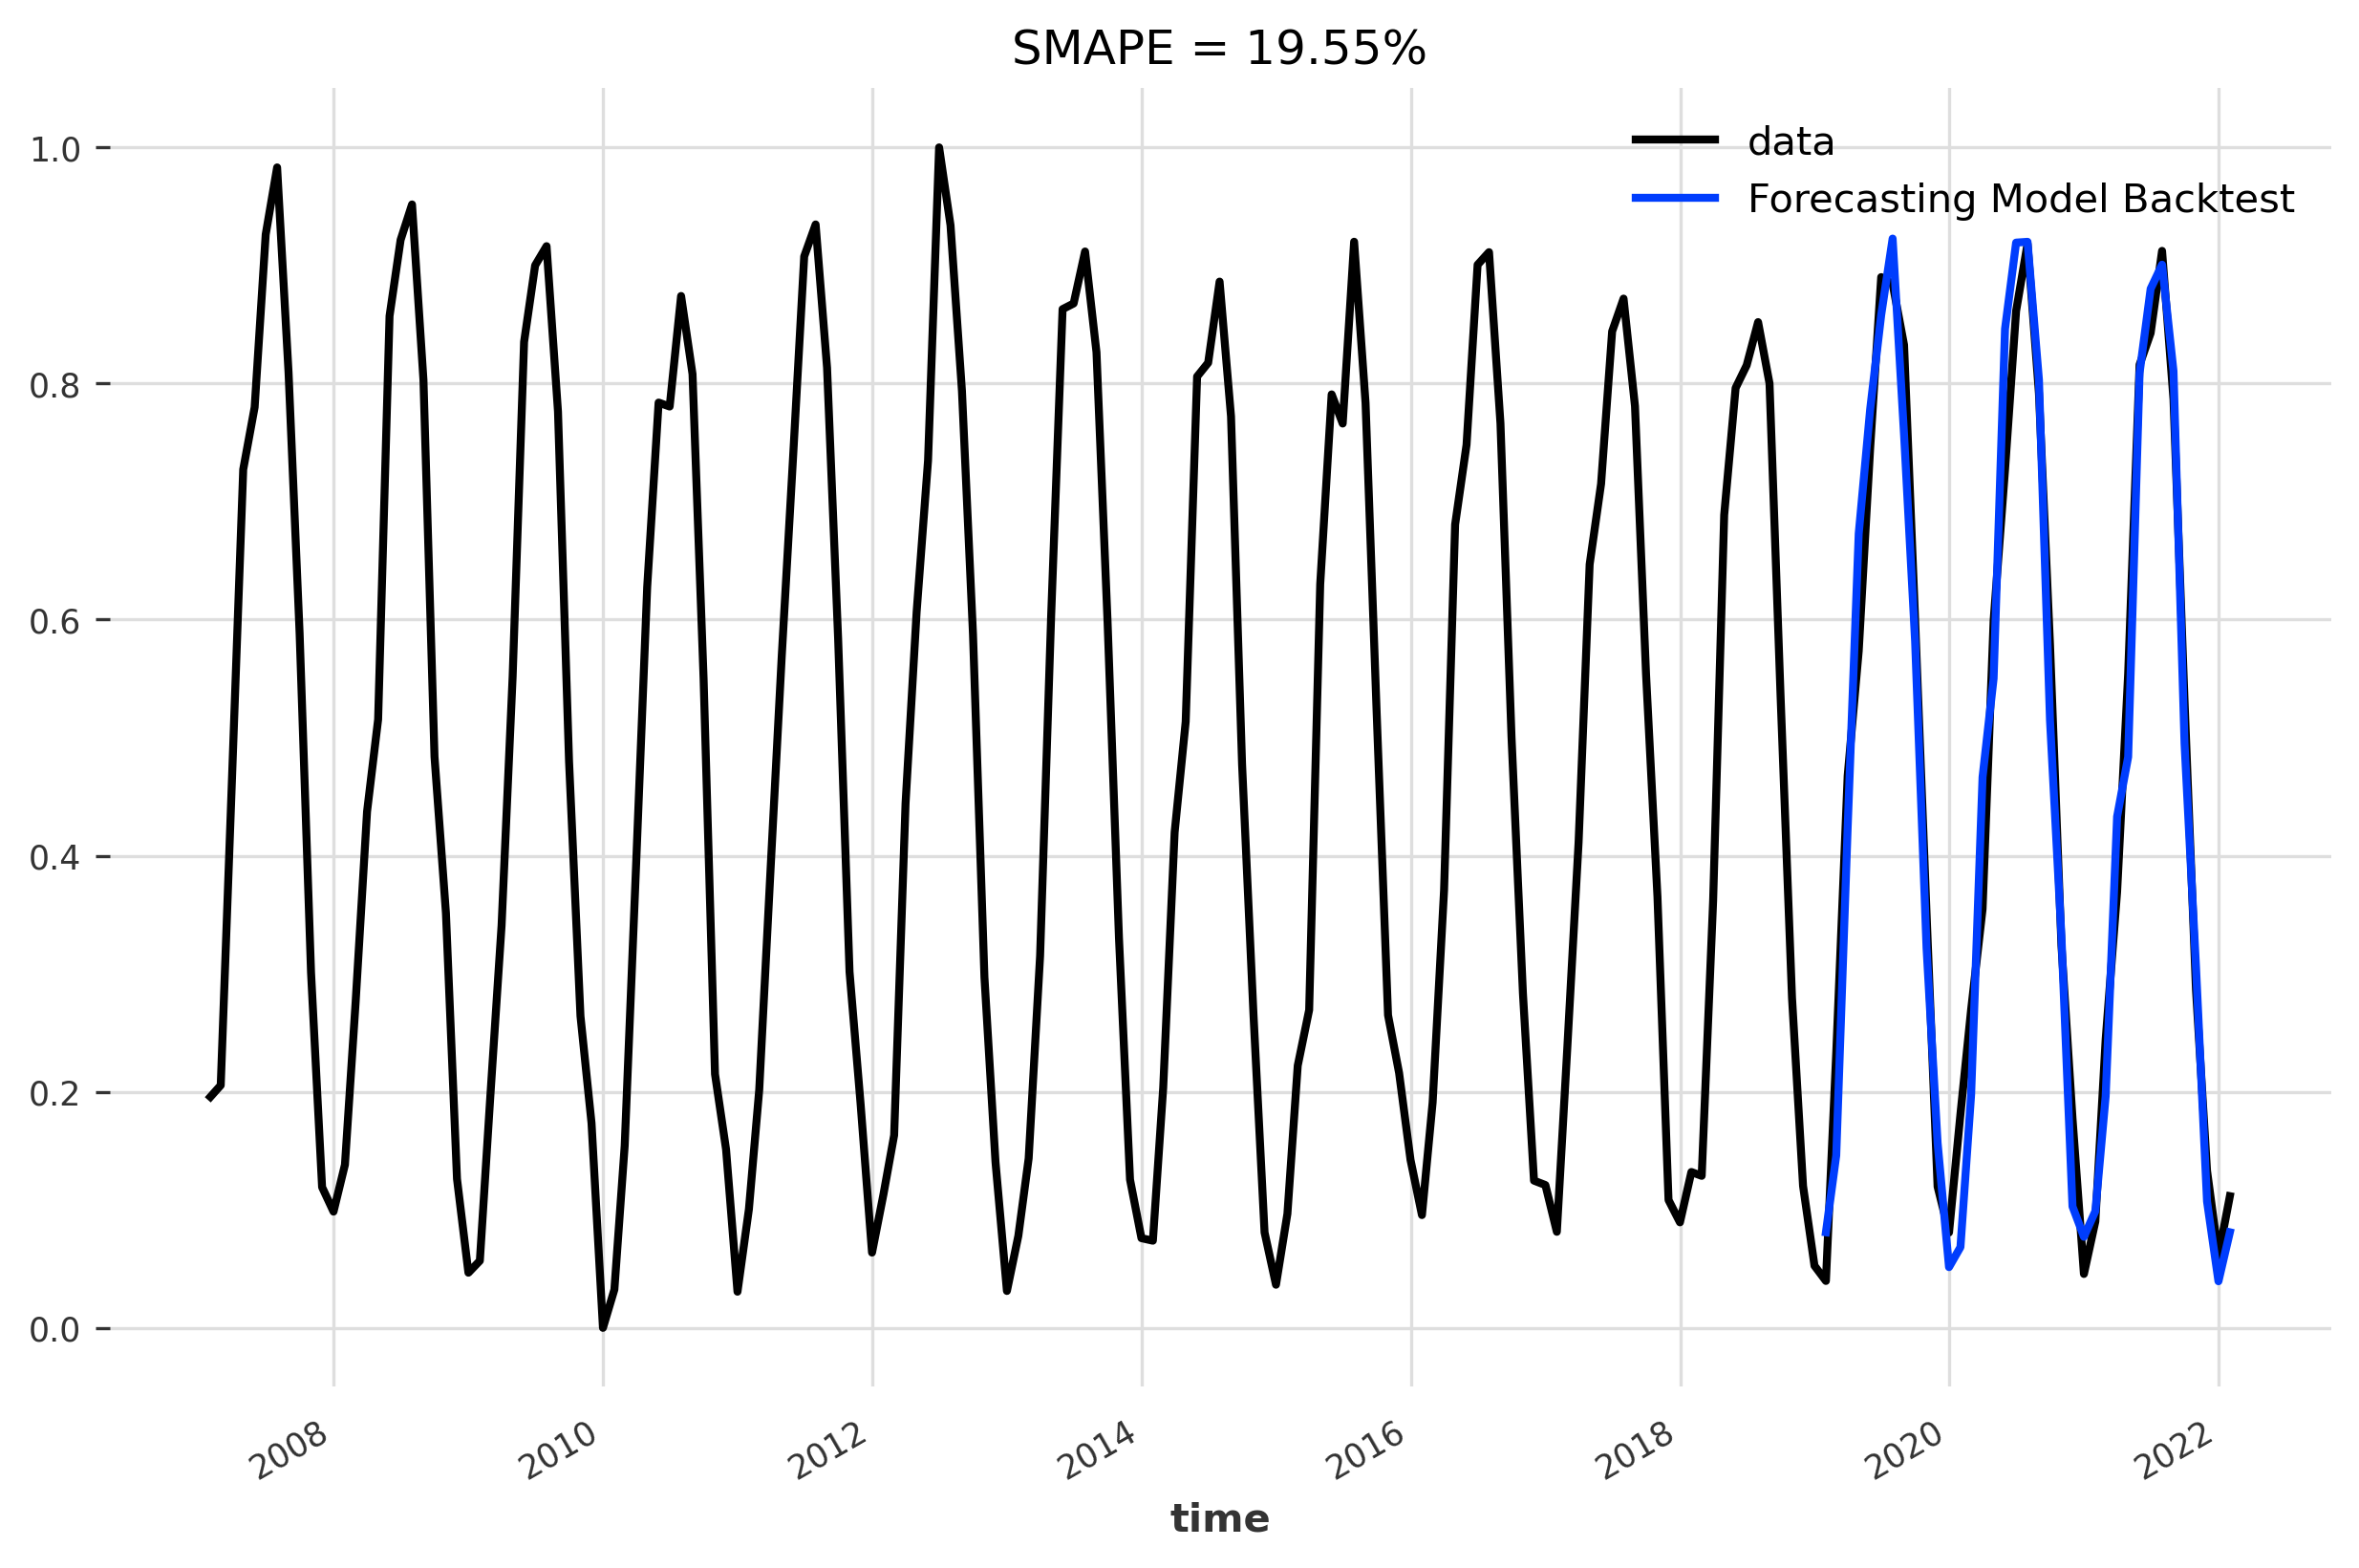

In [11]:
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

start = pd.Timestamp('20190131')

plt.figure(figsize = (10, 6))

plot_backtest(series_scaled, model, start)

plt.show()

### Creating a N-BEATS Forecasting Model

  0%|          | 0/37 [00:00<?, ?it/s]

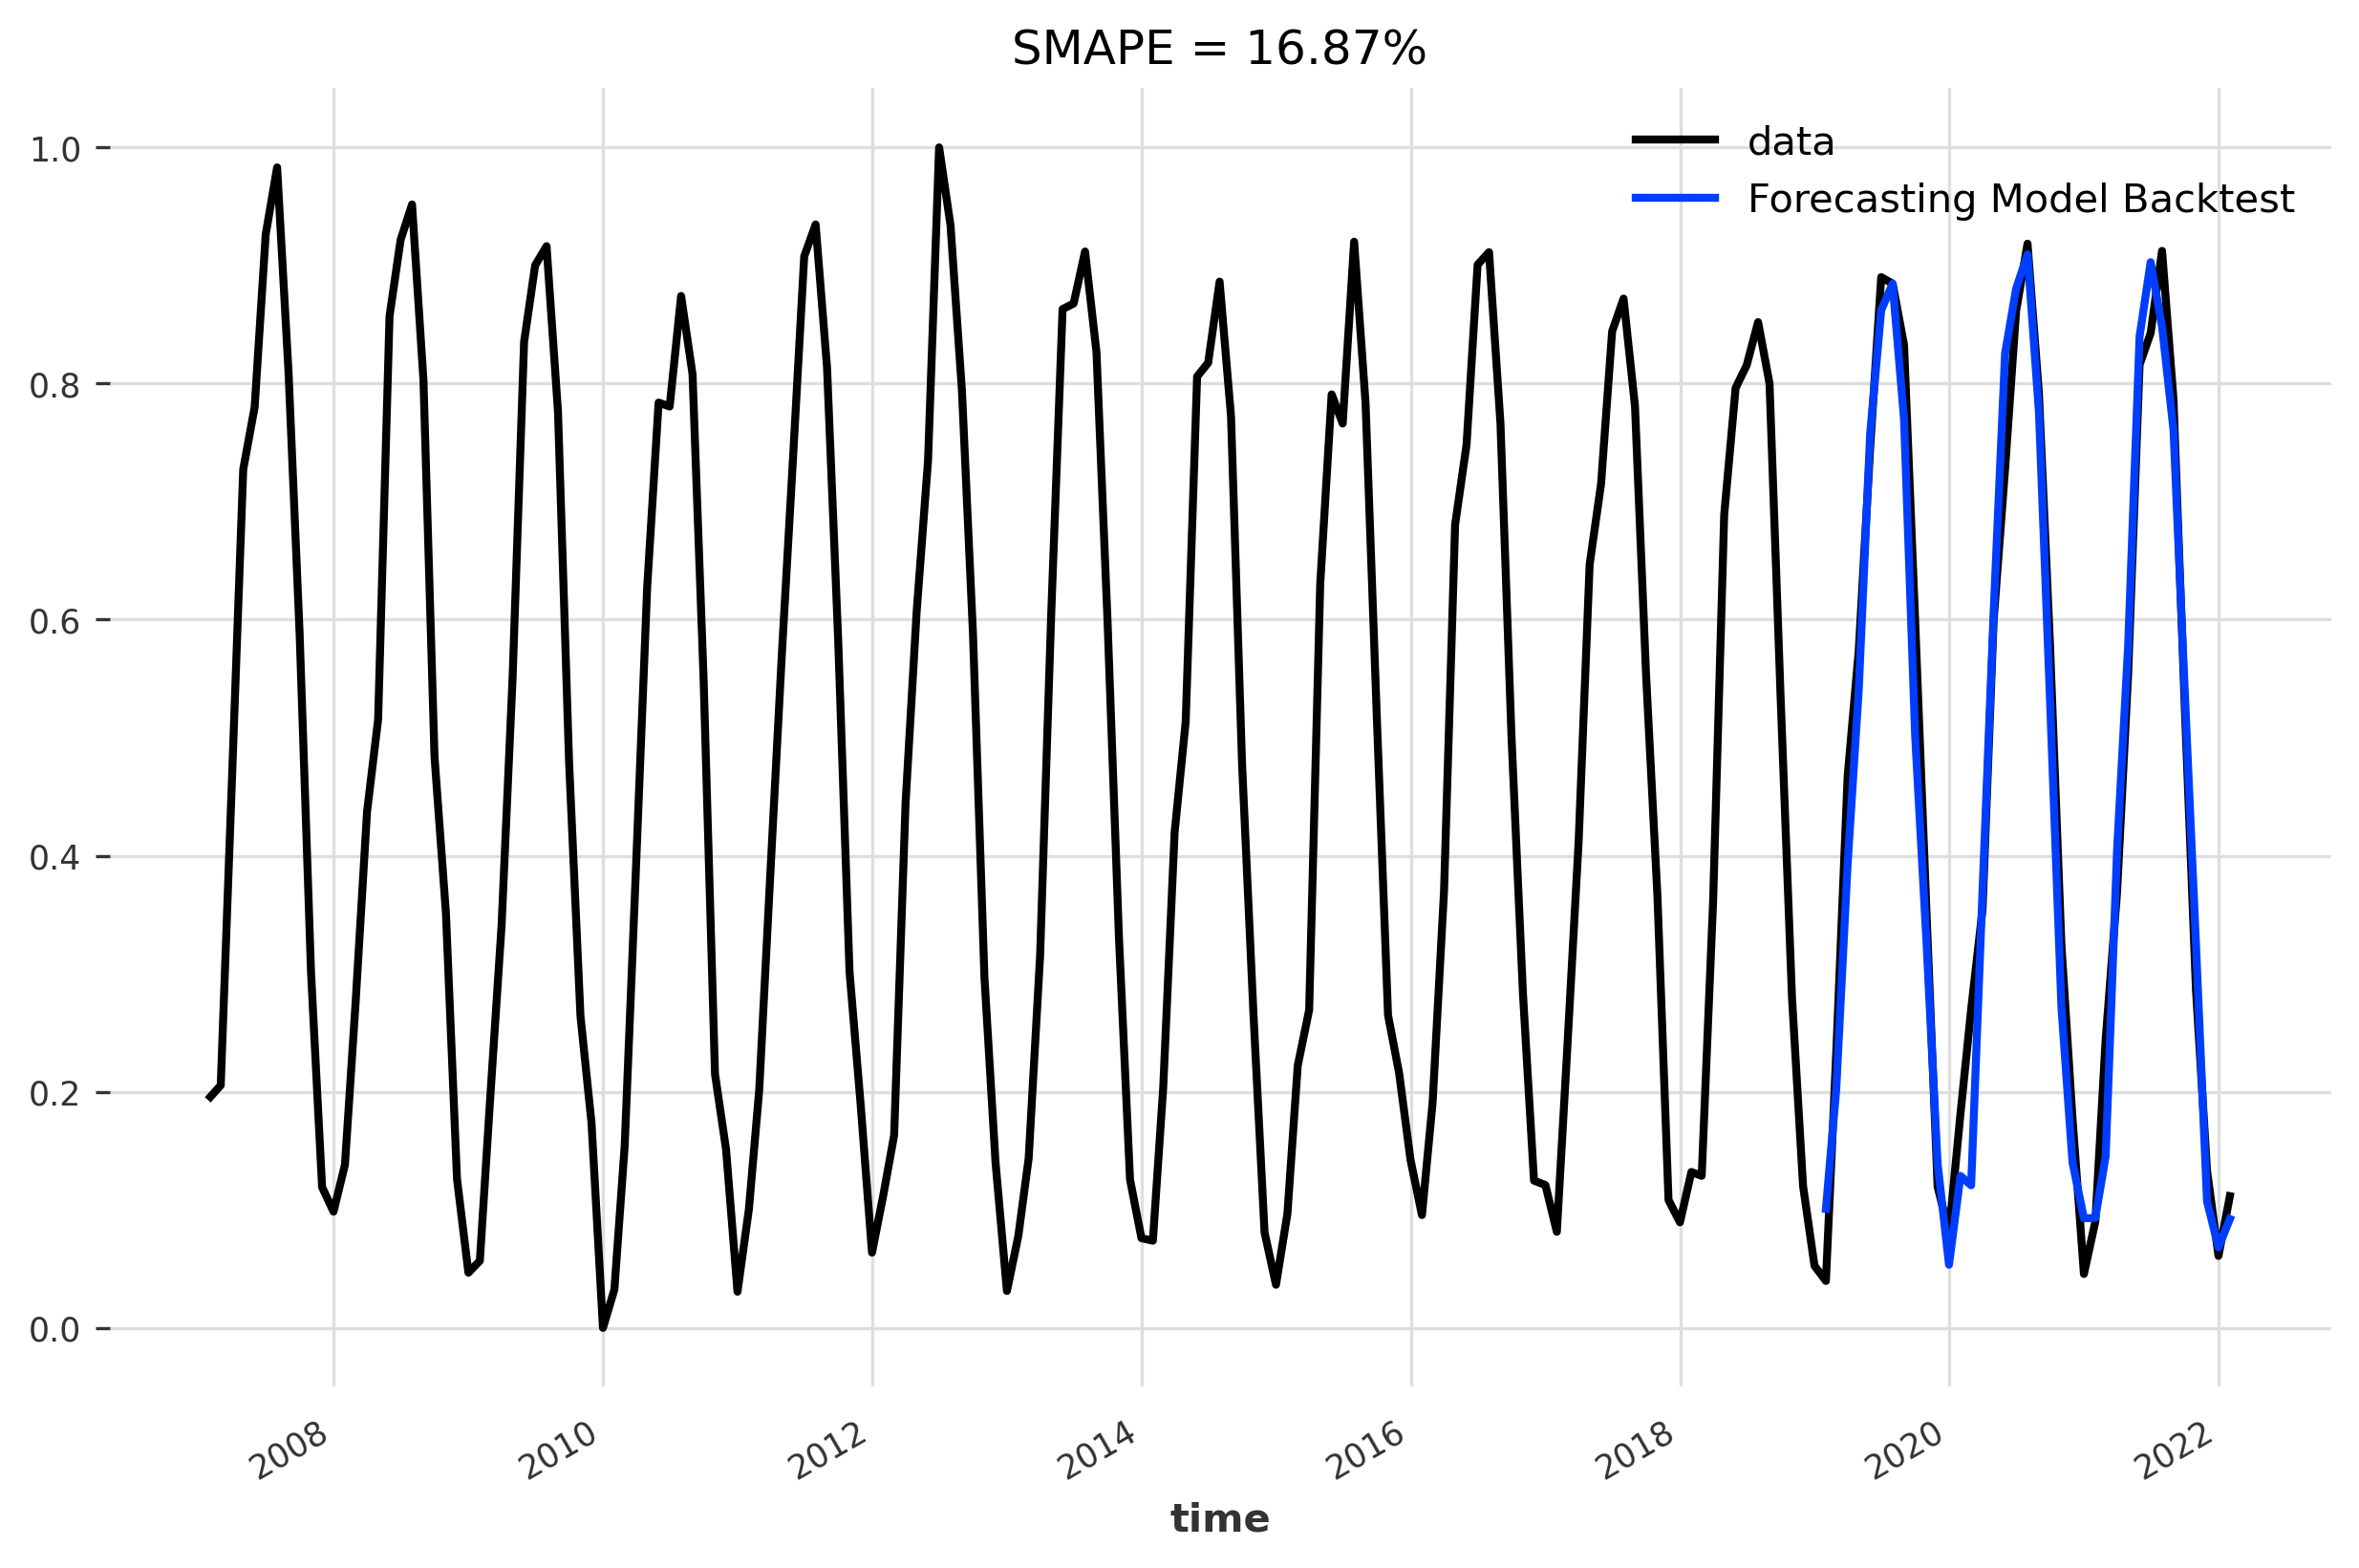

In [12]:
model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats",
)

start = pd.Timestamp('20190131')

plt.figure(figsize = (10, 6))

plot_backtest(series_scaled, model, start)

plt.show()

### Creating a TCN Forecasting Model

  0%|          | 0/37 [00:00<?, ?it/s]

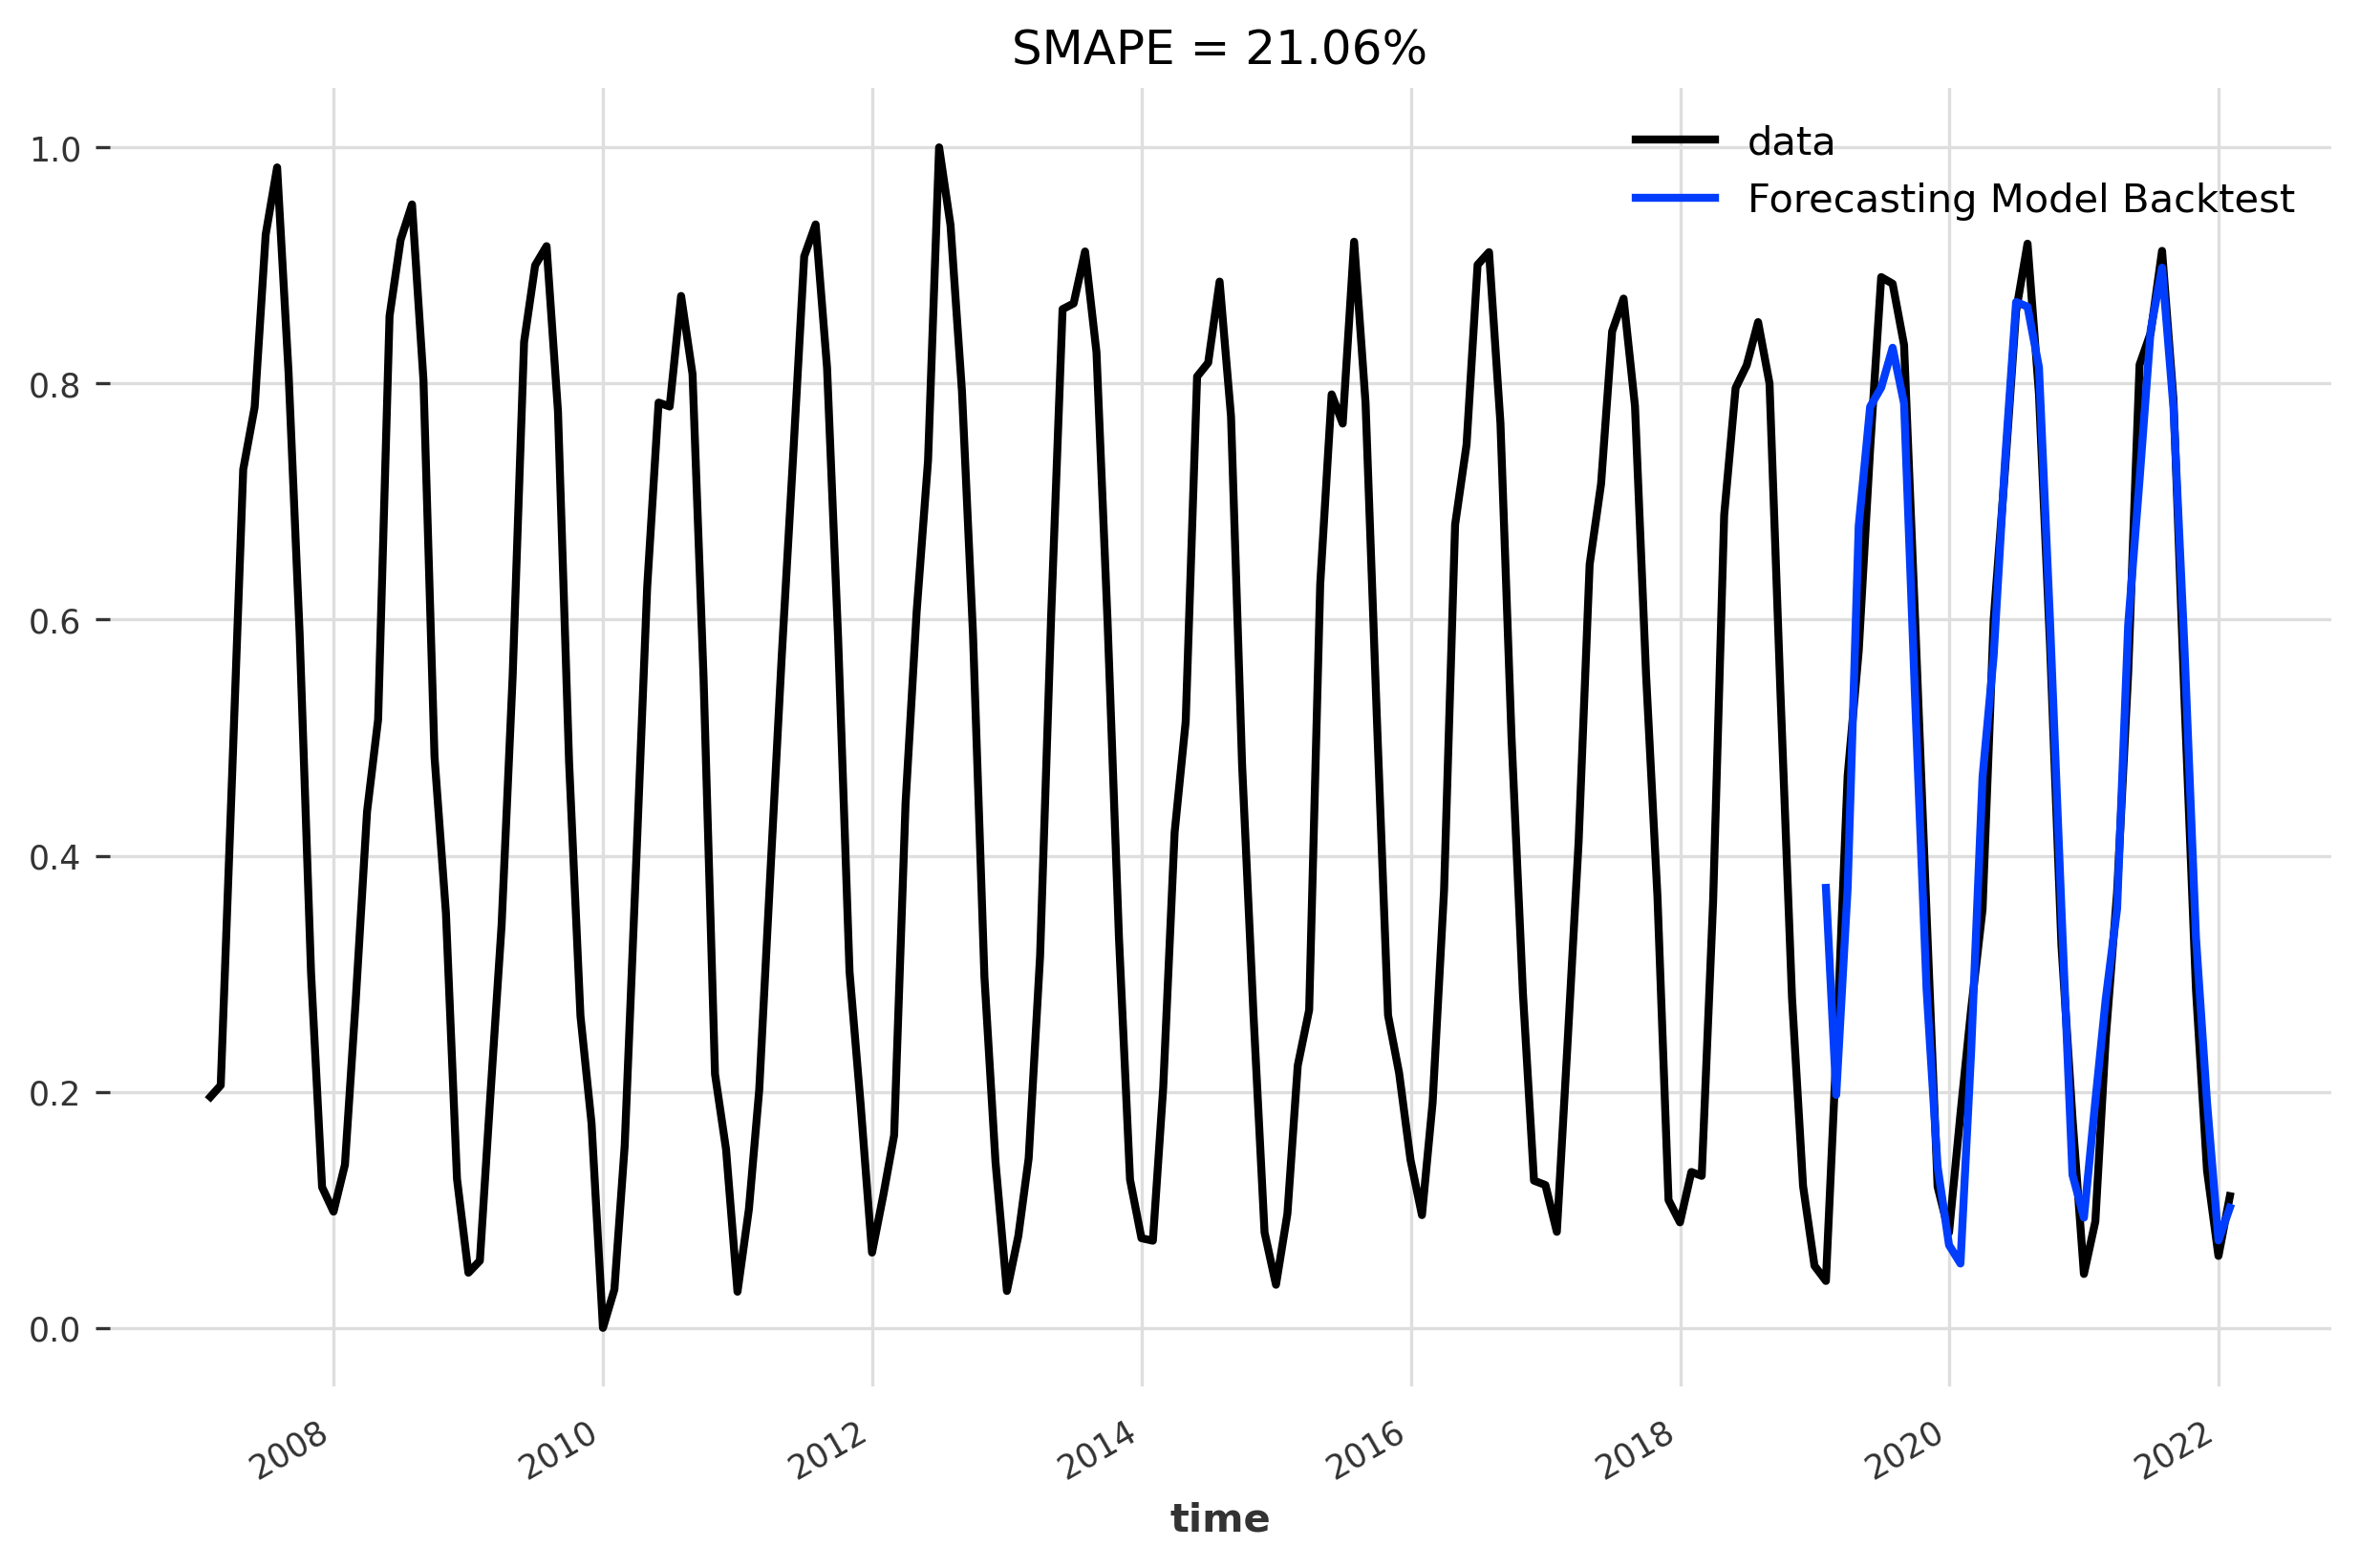

In [13]:
model = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=100,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)

start = pd.Timestamp('20190131')
plt.figure(figsize = (10, 6))

plot_backtest(series_scaled, model, start)

plt.show()